In [2]:
!pip install tensorflow

In [1]:
!pip install gym

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import gym
import random
from collections import deque

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

In [11]:
class DeepQNetwork(tf.keras.Model):
    def __init__(self, n_actions, fc1_dims=32, fc2_dims=32):
        super(DeepQNetwork, self).__init__()
        self.dense1 = layers.Dense(fc1_dims, activation='relu')
        self.dense2 = layers.Dense(fc2_dims, activation='relu')
        self.output_layer = layers.Dense(n_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)


In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995, lr=0.001, batch_size=64,
                 memory_size=100000):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.model = DeepQNetwork(action_size)
        self.model.build(input_shape=(None, state_size))
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.loss_function = tf.keras.losses.MeanSquaredError()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model(np.array([state]))
        return np.argmax(q_values.numpy()[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states = np.array([transition[0] for transition in minibatch])
        actions = np.array([transition[1] for transition in minibatch])
        rewards = np.array([transition[2] for transition in minibatch])
        next_states = np.array([transition[3] for transition in minibatch])
        dones = np.array([transition[4] for transition in minibatch])

        target_qs = self.model(states).numpy()
        next_qs = self.model(next_states).numpy()

        for i in range(self.batch_size):
            target_qs[i, actions[i]] = rewards[i] + \
                (1 - dones[i]) * self.gamma * np.max(next_qs[i])

        with tf.GradientTape() as tape:
            q_pred = self.model(states)
            loss = self.loss_function(target_qs, q_pred)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [10]:
import matplotlib.pyplot as plt

def plot_training(scores, epsilons, window=100):
    # Calculate moving average of scores
    moving_avg = []
    for i in range(len(scores)):
        start = max(0, i - window + 1)
        moving_avg.append(np.mean(scores[start:i+1]))

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(scores, label='Episode Reward')
    plt.plot(moving_avg, label=f'{window}-Episode Moving Average', linewidth=3)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epsilons)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')

    plt.tight_layout()
    plt.show()


In [12]:
def main():
    env = gym.make('CartPole-v1')
    n_episodes = 500
    max_steps = 500
    scores = []
    epsilons = []

    agent = DQNAgent(state_size=env.observation_space.shape[0],
                     action_size=env.action_space.n)

    for episode in range(n_episodes):
        state = env.reset()
        done = False
        score = 0

        for step in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, int(done))
            state = next_state
            score += reward
            if done:
                break

            agent.replay()

        scores.append(score)
        epsilons.append(agent.epsilon)
        avg_score = np.mean(scores[-100:])
        print(f'Episode {episode+1}, Score: {score}, Average: {avg_score:.2f}, Epsilon: {agent.epsilon:.3f}')

        if avg_score >= 475.0:
            print("🎉 Solved CartPole-v1!")
            break

    plot_training(scores, epsilons)

    env.close()


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'deep_q_network_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build

Episode 1, Score: 25.0, Average: 25.00, Epsilon: 1.000
Episode 2, Score: 15.0, Average: 20.00, Epsilon: 1.000
Episode 3, Score: 11.0, Average: 17.00, Epsilon: 1.000
Episode 4, Score: 14.0, Average: 16.25, Epsilon: 0.995
Episode 5, Score: 35.0, Average: 20.00, Epsilon: 0.839
Episode 6, Score: 30.0, Average: 21.67, Epsilon: 0.726
Episode 7, Score: 19.0, Average: 21.29, Epsilon: 0.663
Episode 8, Score: 26.0, Average: 21.88, Epsilon: 0.585
Episode 9, Score: 10.0, Average: 20.56, Epsilon: 0.559
Episode 10, Score: 18.0, Average: 20.30, Epsilon: 0.513
Episode 11, Score: 15.0, Average: 19.82, Epsilon: 0.479
Episode 12, Score: 11.0, Average: 19.08, Epsilon: 0.455
Episode 13, Score: 9.0, Average: 18.31, Epsilon: 0.437
Episode 14, Score: 16.0, Average: 18.14, Epsilon: 0.406
Episode 15, Score: 11.0, Average: 17.67, Epsilon: 0.386
Episode 16, Score: 12.0, Average: 17.31, Epsilon: 0.365
Episode 17, Score: 10.0, Average: 16.88, Epsilon: 0.349
Episode 18, Score: 9.0, Average: 16.44, Epsilon: 0.335
Epi

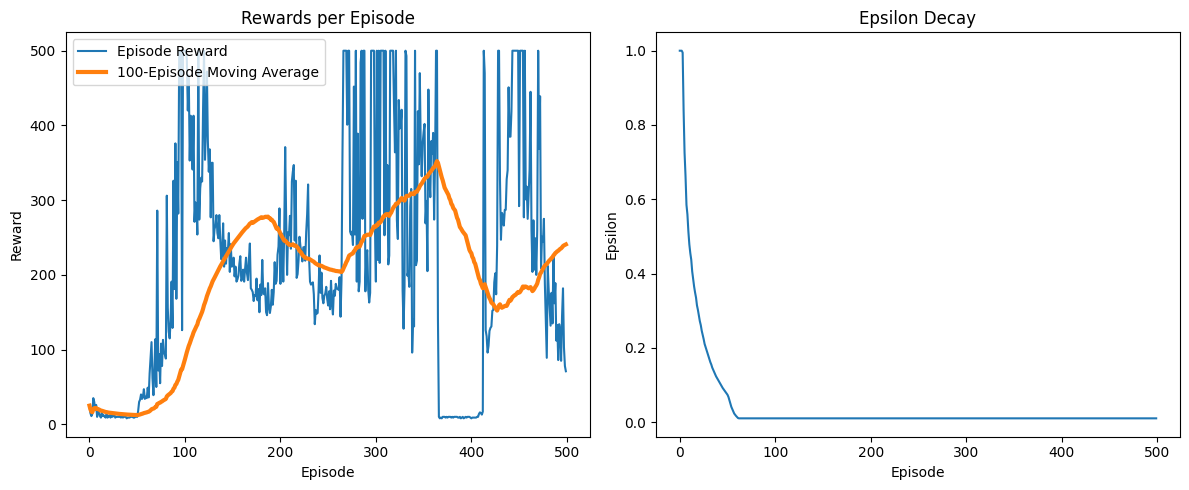

In [13]:
if __name__ == '__main__':
    main()